In [1]:
import pandas as pd
import re
import collections
import tqdm
import itertools
import more_itertools
import tabulate
from tqdm.contrib.concurrent import process_map, thread_map
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import Counter
from nltk.util import ngrams

In [2]:
data = pd.read_csv("/global/u2/m/masare/ticket-text-analysis/bert_ticket_cleaned.csv")


In [3]:
data.head()

,ID,Created,text_data
0,197059,2023-01-18 04:39:28,2023-01-18 04:39:28 scratch purge extension \n...
1,197077,2023-01-18 07:34:40,2023-01-18 07:34:40 re: your nersc account in ...
2,197078,2023-01-18 07:34:43,2023-01-18 07:34:43 re: your nersc account in ...
3,197079,2023-01-18 07:34:45,2023-01-18 07:34:45 re: your nersc account in ...
4,197080,2023-01-18 07:38:44,2023-01-18 07:38:44 re: your nersc account in ...


In [4]:
data[data.ID==197129].text_data.iloc[0]

"2023-01-18 10:33:43 add another majorana project user to the permission list for copesshproxy.sh \n\n\n\nreply from: \n\nthank you very much!\n\n\n\n\nthis should be in place now.\n\n\n yuen-dat,\ni've put in the request to add user chy to the majorana ssh access. you should hear back soon.\n\n,\nlisa\n\n\n(attn: shane canon)\nanother majorana project user needs to be able to use scopesshproxy.sh in order to transfer near time experimental data ( majorana) from surf (south dakota) to nersc (us) . please add her to the permission list, .\n\ninfo for the majorana user is as follows:\nname: chang-hong yu\nusername: chy\n: \n: oak ridge national \n\n added user to scope \n\n\n\nreply from: \n\nthank you very much!\n\n\n\n\n lisa\n\n\nthis should be in place now.\n\n\n yuen-dat,\ni've put in the request to add user chy to the majorana ssh access. you should hear back soon.\n\n,\nlisa\n\n\n shane,\n is at \n\n,\nlisa\n\n\n(attn: shane canon)\nanother majorana project user needs to be able t

In [5]:
patterns = {
    "python": r"(?:python|python3|\S+\.py)", # python, analyze separately
    "GPD": r"(?:kaon_.part_smearing_opt|pion(?:\S+)?|b_minus_Dx)\.exe", # m4240 Lattice QCD code
    "EXCESS": r"exess", # Dr. Giuseppe Barca from The Australian National University (ANU) to port his existing EXtreme-scale Electronic Structure System (EXESS
    "WEST": r"wfreq\.x", 
    "vasp": r"vasp",
    "CP2k": R"cp2k(?:\S+)?", 
    "QE": r"(?:pw|pp|pw2bgw|epw|neb|matdyn|dynmat|dos|pw2wannier90|q2r|ph|turbo_magnon|kgrid|bands|projwfc)\.x", # TODO: add all the other QE binaries
    "LAMMPS": r"lmp(?:-\S+|_\S+)?",
    "NWCHEM": r"nwchem(?:\S+)?",
    "JDFTx": r"jdftx(?:_\S+)?",
    "IOR": r"(?:\/|\b|_)ior(?:\b|_)",
    "OpenMPI": r"(?:prted|orted)",
    "chroma": r"(?:cf_)?chroma(?:\S+)?",
    "Wannier90": r"(?:postw90|wannier90)\.x",
    "E3SM": r"e3sm\.exe",
    "MILC": r"(?:ks_spectrum_hisq|su3_rhmc_hisq|gradientFlow|wilson_flow)(?:\S+)?", # gradientFlow, ks_spectrum_hisq
    "QLUA": r"qlua", # https://usqcd-software.github.io/QLUA.html
    "Gromacs": r"gmx", 
    "BerkeleyGW": r"(?:hdf2wfn|kernel|absorption|epsilon|summarize_eigenvectors|siesta2bgw|sigma|eps0sym|epsinvomega|nonlinearoptics|inteqp|parabands|plotxct|siesta2bgw|wrapper_epsilon)\.(?:cplx|real)?\.x(?:\S+)?",
    "QMCPACK": r"qmcpack",
    "OmniFold": r"omnifold", # https://github.com/hep-lbdl/OmniFold
    "ONTEP" : r"onetep",
    "WRF": r"wrf(?:\.|_)(?:\S+)?(?:exe|py|io|wy2017)(?:\S+)?",
    "COAWST": r"coawstM", # https://www.usgs.gov/centers/whcmsc/science/coawst-a-coupled-ocean-atmosphere-wave-sediment-transport-modeling-system
    "M3GNet": r"M3GNet", # "https://github.com/materialsvirtuallab/m3gnet
    "LALIBE": r"lalibe", # https://github.com/callat-qcd/lalibe
    "nvidia-smi": r"nvidia-smi",
    "Octo-Tiger": r"octotiger", # https://octotiger.stellar-group.org
    "GWU-QCD": r"(?:overlap_curseq|overlap_inverter|2pt_cfun_calc_milc2kentucky|wilsoninverter)", # https://arxiv.org/abs/2001.05706, m102
    "CPS": r"(?:staggered_\S+|wilsoninverter(?:\S+)CPS)", # Columbia Physics System Lattice QCD, intersection with GWU?
    "XGC": r"xgc(?:20230618|_|-es|-eem|-s|-gpu|-no_gpu|a-cpp)(?:\S+)?", # XGC (incl. xgca) https://epsi.pppl.gov/computing/xgc-1
    "XGCm": r"XGCm", # https://xgcm.readthedocs.io/en/latest/index.html
    "halld_recon": r"halld_recon", # JLab GLUEx workflow engine swif https://halldweb.jlab.org/DocDB/0037/003793/002/NERSC_AY2018_Hall_D.pdf
    "OSIRIS": r"osiris", # https://picksc.physics.ucla.edu/osiris.html
    #"GENE": r"\sgene(?:|_\S+)", #pattern matched as GENE instead of generates #added b and \b for the white space but ended up getting errors
    "shifter": r"shifter", # containers (shifter)
    "podman": r"podman-hpc", # containers (podman-hpc)
    "flux": r"flux", # flux workflow manager
    "Athena++": r"athena", # maybe nocr_athhena doesn't belong? # https://www.athena-astro.app
    "WarpX": r"warpx",
    "HPL": r"xhpl",
    "AToM-2 SciDAC": r"(?:xolotl|run_parallel\.exe)", # https://github.com/ORNL-Fusion/xolotl, run_parallel also used in m3195, 
    "EPOCH": r"epoch3d", # (Extendable PIC Open Collaboration)
    "CGYRO": r"cgyro", # https://gafusion.github.io/doc/cgyro.html, OpenACC Fortran
    "DFT-FE": r"dftfe", # https://sites.google.com/umich.edu/dftfe
    "M3D-C1": r"m3dc1(?:\S+)?", # https://m3dc1.pppl.gov
    "Tristan": r"tristan", # https://princetonuniversity.github.io/tristan-v2/
    "Fornax": r"fornax", # https://www.astro.princeton.edu/~burrows/scidac4/fornax.html
    "ChronusQ": r"chronusq", # https://arxiv.org/abs/1905.01381, https://github.com/xsligroup/chronusq_public MPI C++ OpenMP (gpu?)
    "VORPAL": r"vorpal",  # 10.1016/j.jcp.2003.11.004 C++
    "ACE3P": r"track3p", # https://abpcomputing.web.cern.ch/codes/codes_pages/ACE3P/
    "QDP++": r"(?:qdpxx|DStill)", # /global/cfs/cdirs/m2986/software/perlmutter/code-qdpxx-6-2-23-gpu/install/wit/bin/DStill"
    "FLASH": r"flash", # https://flash.rochester.edu/site/flashcode/
    "MCFM": r"mcfm", # "https://mcfm.fnal.gov"
    "TaskFarmer": r"tf_worker", # TaskFarmer workflow manager
    "VLASIATOR": r"vlasiator", # https://www.helsinki.fi/en/researchgroups/vlasiator
    "PROTEUS": r"proteus", # TODO: but which one? https://github.com/nasa/PROTEUS or https://github.com/erdc/proteus or ???
    "SIESTA": r"siesta", # mat sci code
    "SW4": r"sw4", # Seismic
    "Gkeyll": r"gkyl", #  https://github.com/ammarhakim/gkyl C++ CUDA NCCL
    "Trillinos": r"Tpetra",
    "Petra-M": r"petram(?:s|p)", # /global/common/software/petram/20230724/src/PetraM_Driver/README.md
    "HACC": r"hacc",
    "CESM": r"cesm",
    "Maestro": r"Maestro",
    "ATS": r"(?:\/|\b)ats",  # TODO: review this pattern... as high potential for false positives
    "NIMROD": r"nimrod",
    "QBOX": r"qbox",
    "ChomboCrunch": r"crunchDriver",
    "FHI-aims": r"aims\.x",
    "phoenix": r"phoenix",
    "MFDn": r"xmfdn",  # xmfdn-vnn-lan , vnn = 2d body, lan = lanczos (lobpcg), xmfdn-(h2|vnn)-(lan|lobpcg)
    "Julia": r"(?:julia|\S+\.jl)",
    "SOLPS": r"b2mn\.exe",
    "MetaHipMer": r"mhm2",
    "CQL3d": r"xcql3d",
    "NCCL Benchmark": r"all_reduce_perf",
    "Fireworks": r"(?:continuous|repacking)_rlaunch(?:\S+)?\.sh", # Fireworks workflow tool, Materials Genome among others, repacking_rlaunch_perlmutter.sh
    "DFTB+": r"dftb\+", 
    "Hadrons": r"HadronsXmlRun(?:\S+)?", # https://aportelli.github.io/Hadrons-doc/#/ Grid based Lattice QCD workflows
    "AMReX": r"main3d\.", # name.compiler.arch.type.opt.gpu.ex ?
    "stochasticGW": r"sgw_perl\.x",
    "PeleC": r"PeleC",
    "Octopus": r"octopus",
    "GTC": r"gtc",  # TODO: review this pattern... as high potential for false positives
    "GTS": r"gts",  # TODO: review this pattern... as high potential for false positives
    "NVIDIA Tools": r"(?:nsys|ncu|nvprof)", # Nsight systems, compute
    "CUDA-gdb": r"cuda-gdb",
    "GAMESS": r"gamess",
    "DASK": "dask-worker", # fold into "python" ?
    "OSU Benchmarks": r"osu_\S+",
    "PARATEC": r"paratec",
    "valgrind": r"valgrind",
    "Berkeley-CS267": r"kmer_hash_(?:19|51)", #https://github.com/Berkeley-CS267/hw3kmer_hash_51
    "gdb": r"gdb",
    "Check MPI": r"check-(?:mpi|hybrid)\.(?:\S+)\.pm", # NERSC provided
    "ARM Forge": r"forge-backend", # ARM Forge debugger
    "MATLAB": r"matlab",
    "ABINIT": r"abinit",
    "YAMBO": r"yambo",
    "PolyFTS": r"PolyFTS",
    "STREAM": r"stream",
    "WEST": r"w(?:stat|freq|bse)\.x",
    "NCO": r"\snc(?:remap|ks|diff|bo|es|rcat|add|substract|multiply|divide|pack|unpack)", # https://nco.sourceforge.net/nco.html, look into this pattern well
    "SuperLU": r"superlu_dist",
    "GEMM": r"gemm", # DGEMM benchmark
    "ALICE": r"(?:process_LHC|process_embed|process_mc|alicepro|\/alice\/)", # ALICE experiment data processing process_LHC18f5b.sh
    "MOLPRO": r"molpro",
    #"DESI": r"desi",
    "WRF": r"wrf",
    "E3SM": r"E3SM",
    "Alphafold": "af2c", # /global/u1/m/mugao/projects/af2complex/git/src
    "Fungal/Algal Genome annotation": r"fnglanot",
    "TOAST": r"toast",
    "GX": r"gx", # nmandell, https://gx.rtfd.io
    "KBASE": r"kbase",
    "QTools": r"qtools",
    "PyZFS": r"pyzfs", #     https://github.com/hema-ted/pyzfs
    "FHI-aims": r"fhi(?:\S+)aims",
    "Chombo": r"(?:\S+)\.Linux\.64\.(?:g\+\+|CC)\.ftn\.(?:\S+)\.ex", # e.g. driver2d.Linux.64.g++.ftn.OPT.MPI.PETSC.ex
    "PFLOTRAN": r"pflotran",
    "NRQCD": r"NRQCD", # /global/cfs/cdirs/m3760/Wei-Ping/measure/NRQCD
}

compiled_patterns = {
    name: re.compile(pattern, re.IGNORECASE)
    for name, pattern in patterns.items()
}

In [6]:
def match(string, patterns):
    applications = []
    for name, pattern in patterns.items():
        #print(name)
        #print(applications)
        if pattern.search(string):
            #print("found", name)
            applications.append(name) 
    return applications

def f(x):
    return match(x, compiled_patterns)

In [7]:
%%time
names = process_map(f, data['text_data'], max_workers=32, chunksize=1000) #play with the numbers

  0%|          | 0/2816 [00:00<?, ?it/s]

CPU times: user 46.7 ms, sys: 261 ms, total: 307 ms
Wall time: 8.77 s


In [8]:
data.insert(2,"Applications",names,True)

In [9]:
data['text_data'][20]

'2023-01-18 08:03:18 re: your nersc account in the new allocation year \n\n\n\n.\n\n\n yang,\n\nyou will need to submit an ercap proposal to renew your projects. here is some information on how to do that: \n\nkeep in mind that the deadline for submitting ay 2023 nersc proposals (both renewed and new) was october 7, 2022, 5:00 pm pacific time. so the doe allocation managers have already reviewed and approved the projects that submitted the proposals on time. award emails were sent out in december to the pis who were allocated time.\n\nyou can still submit a proposal and it will be up to the allocation managers on what they are able award from what they have remaining.\n\nregards,\nbecci totzke\nallocations and account support\n\n\ndear nersc account support,\n\nthank you for your note, but we do need to continue both projects on nersc.\ni am the pi for this project, \nshould i submit renewal request?  if so, could you please provide an instruction where to submit the renewal request?\n

In [10]:
match(data['text_data'][0], {"k": re.compile('Lisa', re.IGNORECASE), "p": re.compile('thanks', re.IGNORECASE)})

['k']

In [11]:
#counting occurrences of each match
match_counts = data['Applications'].value_counts()

In [12]:
print ('\nCounts of each applications')
print(match_counts)


Counts of each applications
Applications
[]                                    2136
[vasp]                                 159
[python]                               124
[OpenMPI]                               80
[E3SM]                                  54
                                      ... 
[E3SM, WRF]                              1
[OpenMPI, HACC]                          1
[E3SM, shifter, gdb]                     1
[vasp, CGYRO]                            1
[python, OpenMPI, shifter, podman]       1
Name: count, Length: 112, dtype: int64


In [13]:
#most common match
most_common_match = match_counts.idxmax()
most_common_match_count = match_counts.max()
print(f"\nMost common match: {most_common_match} with {most_common_match_count} occurrences") 


Most common match: [] with 2136 occurrences


In [14]:
#filter out empty matches
filtered_data = data[data['Applications'] != '']


In [15]:
# Count the occurrences of each match
match_counts = filtered_data['Applications'].value_counts()

# Display the counts of each match
print("\nCounts of each match:")
print(match_counts)

# Find the most common match and its count
most_common_match = match_counts.idxmax()
most_common_match_count = match_counts.max()

print(f"\nMost common match: {most_common_match} with {most_common_match_count} occurrences")

#select the top N most common matches
N = 2
top_n_matches = match_counts.head(N)

print(f"\nTop {N} most common matches:")
print(top_n_matches)

# Calculate the total number of occurrences for the top N matches
total_top_n_matches = top_n_matches.sum()

#print(f"\nTotal occurrences of the top {N} matches: {total_top_n_matches}")




Counts of each match:
Applications
[]                                    2136
[vasp]                                 159
[python]                               124
[OpenMPI]                               80
[E3SM]                                  54
                                      ... 
[E3SM, WRF]                              1
[OpenMPI, HACC]                          1
[E3SM, shifter, gdb]                     1
[vasp, CGYRO]                            1
[python, OpenMPI, shifter, podman]       1
Name: count, Length: 112, dtype: int64

Most common match: [] with 2136 occurrences

Top 2 most common matches:
Applications
[]        2136
[vasp]     159
Name: count, dtype: int64


In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

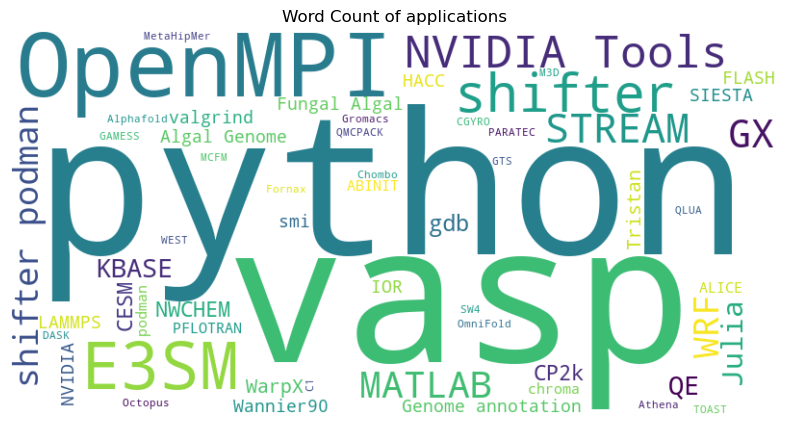

In [17]:
#Word Cloud Visuals 

# Combining all the matches into a single string
all_matches = ' '.join([' '.join(match) if isinstance(match, list) else match for match in filtered_data['Applications']])

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_matches)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Count of applications')
plt.show()




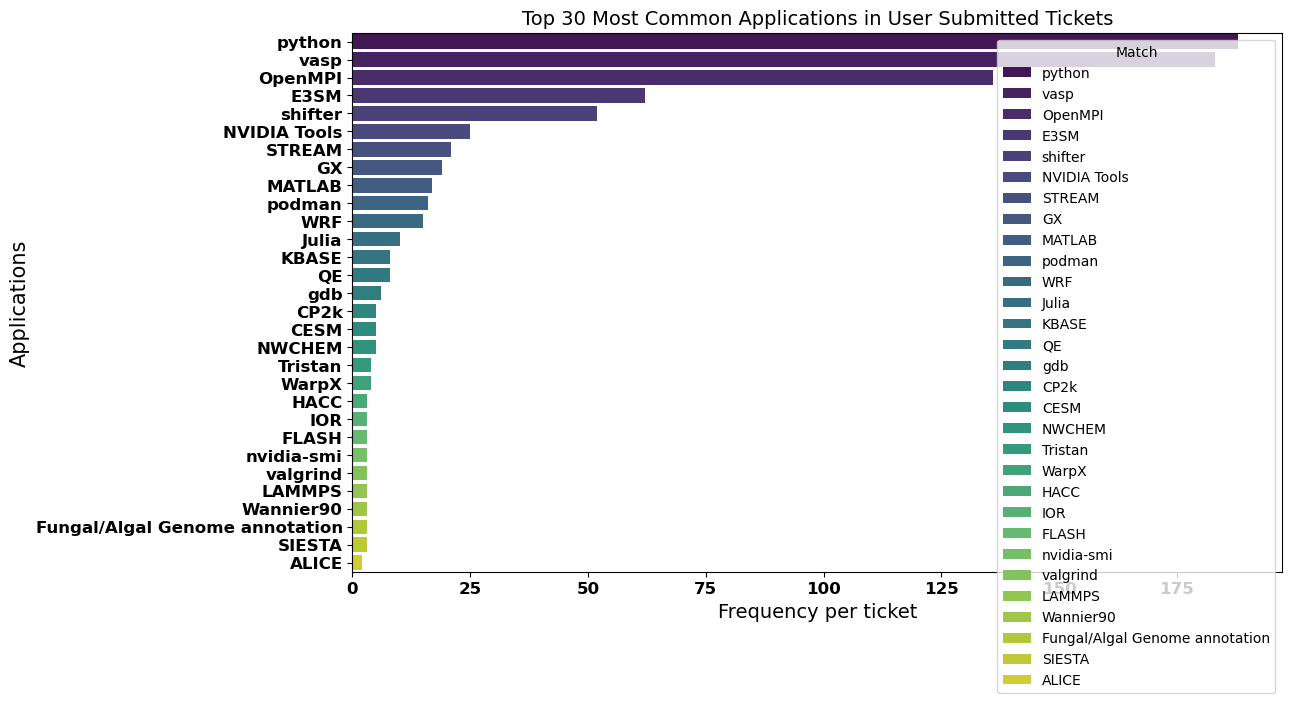

In [18]:
# Bar Plot of Most Common Applications

# Flatten the list of matches and count the occurrences of each match
flattened_matches = [match for sublist in filtered_data['Applications'] for match in (sublist if isinstance(sublist, list) else [sublist])]
match_counts = Counter(flattened_matches)

# Converting to a DataFrame for plotting
match_counts_df = pd.DataFrame(match_counts.items(), columns=['Match', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top N most common words
N = 30
top_n_words = match_counts_df.head(N)

plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Match', data=top_n_words, palette='viridis', hue='Match',legend=True, dodge=False)
plt.xlabel('Frequency per ticket', fontsize=14)
plt.ylabel('Applications', fontsize=15)
plt.title(f'Top {N} Most Common Applications in User Submitted Tickets',fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()



In [19]:
# 2D PREP
patterns2 = {
    "login": r"(?i)\blogin\b",
    "license": r"(?i)\blicense\b",
    "password": r"(?i)\bpassword\b",
    "error": r"(?i)\berror\b",
    "crash": r"(?i)\bcrash\b",
    "configuration": r"(?i)\bconfiguration\b",
    "backup": r"(?i)\bbackup\b",
    "restore": r"(?i)\brestore\b",
    "network outage": r"(?i)\bnetwork\boutage\b",
    "log-in": r"(?i)\blog-in\b",
    "activation": r"activation",
    "blocked": r"(?i)\bblocked\b",
    "locked": r"(?i)\blocked\b",
    "approval": r"(?i)\bapproval\b",
    "mfa": r"(?i)\bmfa\b",
    "quota": r"(?i)\bquota\b",  
    "connect": r"(?i)\bconnect\b",
    "compile": r"(?i)\bcompile\b",
    "link": r"(?i)\blink\b",
    "build": r"(?i)\bbuild\b",
    "make": r"(?i)\bmake\b",
    "timeout": r"(?i)\btimeout\b",
    "freeze": r"(?i)\bfreeze\b",
    "unresponsive": r"(?i)\bunresponsive\b",
    "lag": r"(?i)\blag\b",
    "broken": r"(?i)\bbroken\b",
    "request": r"(?i)\brequest\b",
    "module": r"(?i)\bmodule\b",
    "slow": r"(?i)\bslow\b",
    "profile": r"(?i)\bprofile\b",
    "performance": r"(?i)\bperformance\b",
    "libraries": r"(?i)\blibraries\b",
    "mpi": r"(?i)\bmpi\b",
    "job": r"(?i)\bjob\b",
    "parameter": r"(?i)\bparameter\b",
    "hang": r"(?i)\bhang\b",
    "certificate": r"(?i)\bcertificate\b",
    "automated": r"(?i)\bautomated\b",
    "documentation": r"(?i)\bdocumentation\b",
    "docs": r"(?i)\bdocs\b",
    "stop": r"(?i)\bstop\b",
    "wrong": r"(?i)\bwrong\b",
    "session": r"(?i)\bsession\b",
    "node": r"(?i)\bnode\b",
    "hpe": r"(?i)\bhpe\b",
    "wait": r"(?i)\bwait\b",
    "policy": r"(?i)\bpolicy\b",
    "queue": r"(?i)\bqueue\b",
    "permissions": r"(?i)\bpermissions\b",
    "mpich": r"(?i)\bmpich\b",
    "makefile": r"(?i)\bmakefile\b",
    "crontab": r"(?i)\bcrontab\b",
    "scrontab": r"(?i)\bscrontab\b",
    "disconnect": r"(?i)\bdisconnect\b",
    "user": r"(?i)\buser\b",
    "account": r"(?i)\baccount\b",
    "collab": r"(?i)\bcollab\b",
    "ssh": r"(?i)\bssh\b",
    "closed": r"(?i)\bclosed\b",
    "save": r"(?i)\bsave\b",
    "processes": r"(?i)\bprocesses\b",
    "sharing": r"(?i)\bsharing\b",
    "CFS": r"(?i)\bCFS\b",
    "scratch": r"(?i)\bscratch\b",
    "executable": r"(?i)\bexecutable\b",
    "IO": r"(?i)\bIO\b",
    "CPU": r"(?i)\bCPU\b",
    "GPU": r"(?i)\bGPU\b",
    "intel": r"(?i)\bintel\b",
    "gnu": r"(?i)\bgnu\b",
    "nvidia": r"(?i)\bnvidia\b",
    "cray": r"(?i)\bcray\b",
    "file": r"(?i)\bfile\b",
    "qos": r"(?i)\bqos\b",
    "OS": r"(?i)\bOS\b",
    "shell": r"(?i)\bshell\b",
    "bash": r"(?i)\bbash\b",
    "csh": r"(?i)\bcsh\b",
    "tsh": r"(?i)\btsh\b",
    "ip": r"(?i)\bip\b",
    "compute": r"(?i)\bcompute\b",
    "workflow": r"(?i)\bworkflow\b",
    "memory": r"(?i)\bmemory\b",
    "utilization": r"(?i)\butilization\b",
    "data": r"(?i)\bdata\b",
    "application": r"(?i)\bapplication\b",
    "framework": r"(?i)\bframework\b",
    "realtime": r"(?i)\brealtime\b",
    "allocation": r"(?i)\ballocation\b",
    "reservation": r"(?i)\breservation\b",
    "slurm": r"(?i)\bslurm\b",
    "script": r"(?i)\bscript\b",
    "group": r"(?i)\bgroup\b",
    "membership": r"(?i)\bmembership\b",
    "create": r"(?i)\bcreate\b",
    "access": r"(?i)\baccess\b",
    "issue": r"(?i)\bissue\b",
    "source": r"(?i)\bsource\b"

    #"alloacation_year": r"\ballocation year\b"
}

compiled_patterns2 = {
    name: re.compile(pattern, re.IGNORECASE)
    for name, pattern in patterns2.items()
}

In [20]:
def match(string, patterns):
    issues = []
    for name, pattern in patterns.items():
        #print(name)
        #print(matches)
        if pattern.search(string):
            #print("found", name)
            issues.append(name) 
    return issues

def f(x):
    return match(x, compiled_patterns2)

In [21]:
%%time
names2 = process_map(f, data['text_data'], max_workers=32, chunksize=1000) #play with the numbers

  0%|          | 0/2816 [00:00<?, ?it/s]

CPU times: user 18.2 ms, sys: 302 ms, total: 321 ms
Wall time: 5.94 s


In [22]:
data = pd.DataFrame(data)


In [23]:
data.insert(2,"Issues",names2,True)
data.head()

,ID,Created,Issues,Applications,text_data
0,197059,2023-01-18 04:39:28,"[make, user, scratch, data]",[],2023-01-18 04:39:28 scratch purge extension \n...
1,197077,2023-01-18 07:34:40,"[error, user, account, allocation, access]",[],2023-01-18 07:34:40 re: your nersc account in ...
2,197078,2023-01-18 07:34:43,"[error, request, user, account, allocation, ac...",[],2023-01-18 07:34:43 re: your nersc account in ...
3,197079,2023-01-18 07:34:45,"[error, user, account, data, allocation, group...",[],2023-01-18 07:34:45 re: your nersc account in ...
4,197080,2023-01-18 07:38:44,"[error, user, account, allocation, group, acce...",[],2023-01-18 07:38:44 re: your nersc account in ...


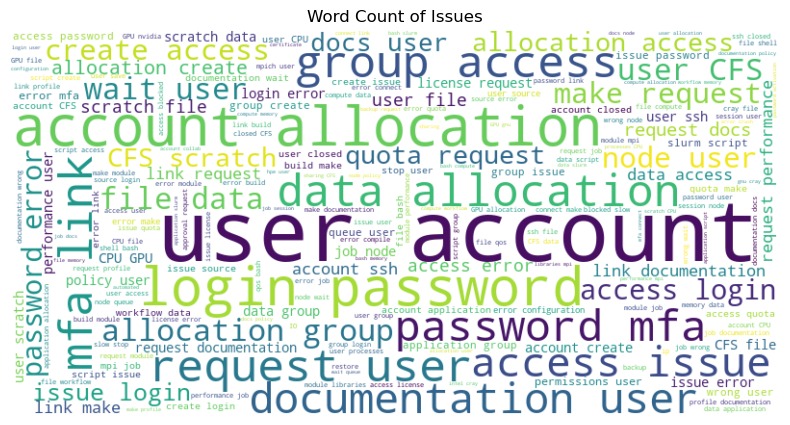

In [24]:
#Word Cloud Visuals 

# Combining all the matches into a single string
all_matches = ' '.join([' '.join(match) if isinstance(match, list) else match for match in data['Issues']])

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_matches)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Count of Issues')
plt.show()



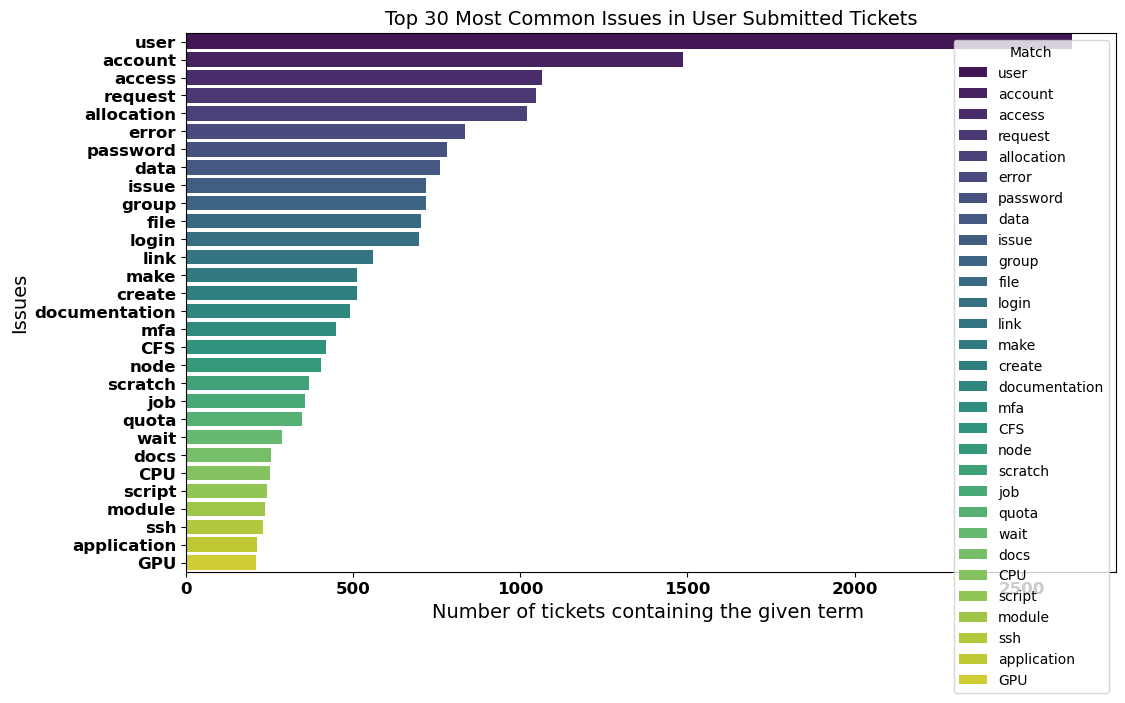

In [25]:
# Bar Plot of Most Common Words

# Flatten the list of matches and count the occurrences of each match
flattened_matches = [match for sublist in data['Issues'] for match in (sublist if isinstance(sublist, list) else [sublist])]
match_counts = Counter(flattened_matches)

# Converting to a DataFrame for plotting
match_counts_df = pd.DataFrame(match_counts.items(), columns=['Match', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the top N most common words
N = 30
top_n_words = match_counts_df.head(N)

plt.figure(figsize=(12, 7))
sns.barplot(x='Frequency', y='Match', data=top_n_words, palette='viridis', hue='Match',legend=True, dodge=False)
plt.xlabel('Number of tickets containing the given term ',fontsize=14)
plt.ylabel('Issues', fontsize=14)
plt.title(f'Top {N} Most Common Issues in User Submitted Tickets', fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()


In [26]:
applications_keywords = [match for sublist in filtered_data['Applications'] for match in (sublist if isinstance(sublist, list) else [sublist])]
issues_keywords = flattened_matches = [match for sublist in data['Issues'] for match in (sublist if isinstance(sublist, list) else [sublist])]

In [27]:
len(issues_keywords)

23367

In [28]:
ik = pd.Series(issues_keywords).value_counts()['closed']

In [29]:
ik

175